***Лабораторная работа №3 "Обучение LSTM/RNN/GRU". Тарбаев Данила Дмитриевич БВТ2202***

Установка необходимых библиотек и импорт

In [1]:
%pip install transformers pandas numpy scikit-learn matplotlib seaborn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


Импорт библиотек

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as notebook_tqdm
import time
import warnings

warnings.filterwarnings('ignore')

# Проверяем доступность CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


Загрузка и анализ данных

toxic
0    0.898321
1    0.101679
Name: proportion, dtype: float64


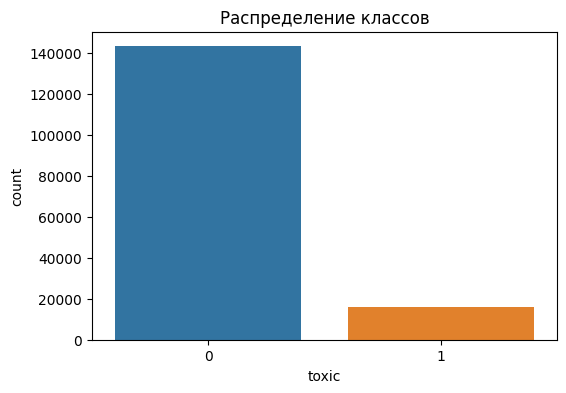

In [5]:
# Загрузка данных из CSV файла
df = pd.read_csv('/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv')

# Преобразуем множественные метки токсичности в одну метку для бинарной классификации:
# Если хотя бы один из столбцов 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate' равен 1,
# то комментарий будет считаться токсичным (1), иначе — нет (0)
df['toxic'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0).astype(int)

# Удаляем ненужные столбцы, оставляем только текст комментария и метку токсичности
df = df[['comment_text', 'toxic']]

# Посмотрим на распределение классов (токсичный/не токсичный)
print(df['toxic'].value_counts(normalize=True))  # Выводим относительную частоту каждого класса

# Строим график для визуализации распределения классов
plt.figure(figsize=(6, 4))  # Размер графика
sns.countplot(data=df, x='toxic')  # Строим столбчатую диаграмму для столбца 'toxic'
plt.title('Распределение классов')  # Заголовок графика
plt.show()  # Отображаем график


Предобработка данных

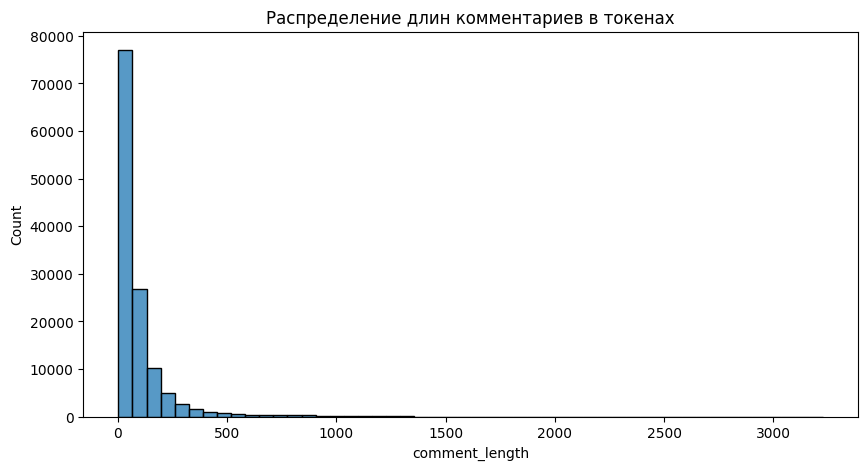

99th percentile of comment length: 822.0


In [6]:
# Разделяем данные на тренировочную и тестовую выборки
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['toxic'])
# Здесь мы делим исходный датасет `df` на две части: 80% для обучения (train_df) и 20% для тестирования (test_df).
# Параметр `stratify` гарантирует, что распределение целевой переменной (toxic) будет одинаковым в обоих наборах.

# Инициализация токенизатора
tokenizer = AutoTokenizer.from_pretrained('allenai/longformer-base-4096')
# Загружаем предварительно обученный токенизатор для модели

MAX_LEN = 850

# Анализируем длину комментариев в тренировочной выборке
train_df['comment_length'] = train_df['comment_text'].apply(lambda x: len(tokenizer.tokenize(x)))
# Для каждого комментария в тренировочной выборке считаем количество токенов (слов) после токенизации.

# Строим гистограмму распределения длин комментариев в тренировочной выборке
plt.figure(figsize=(10, 5))
sns.histplot(train_df['comment_length'], bins=50)
plt.title('Распределение длин комментариев в токенах')
plt.show()
# Строим график, который покажет, как распределяются длины комментариев в виде гистограммы.

# Оценка 99-го перцентиля длин комментариев, чтобы выбрать подходящее значение для MAX_LEN
print(f"99th percentile of comment length: {np.percentile(train_df['comment_length'], 99)}")
# Мы вычисляем 99-й перцентиль длины комментариев, что позволяет понять, на какой длине комментариев стоит остановиться.

Создание Dataset и DataLoader

In [7]:
# Класс датасета для токсичных комментариев
class ToxicCommentsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        # Инициализация датасета: сохраняем текст комментариев, метки и токенизатор
        self.comment_texts = dataframe['comment_text'].values
        self.labels = dataframe['toxic'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Возвращаем количество комментариев в датасете
        return len(self.comment_texts)

    def __getitem__(self, idx):
        # Извлекаем комментарий и его метку
        comment_text = str(self.comment_texts[idx])
        label = self.labels[idx]

        # Применяем токенизацию с настройками для добавления специальных токенов,
        # обрезки или дополнения до максимальной длины
        encoding = self.tokenizer.encode_plus(
            comment_text,
            add_special_tokens=True,  # Добавляем специальные токены [CLS] и [SEP]
            max_length=self.max_len,  # Ограничиваем длину токенов
            padding='max_length',  # Дополняем до максимальной длины
            truncation=True,  # Обрезаем, если текст слишком длинный
            return_attention_mask=True,  # Возвращаем маску внимания
            return_tensors='pt'  # Возвращаем тензоры PyTorch
        )

        # Возвращаем подготовленные данные: input_ids, attention_mask и label
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)  # Преобразуем метку в тензор типа float
        }

# Создаем датасеты для обучения и тестирования
train_dataset = ToxicCommentsDataset(train_df, tokenizer, MAX_LEN)
test_dataset = ToxicCommentsDataset(test_df, tokenizer, MAX_LEN)

# Учитываем дисбаланс классов для взвешивания функции потерь
pos_weight = torch.tensor([len(train_df) / (2 * train_df['toxic'].sum())], device=device)
# Рассчитываем коэффициент веса для положительного класса в функции потерь BCEWithLogitsLoss
print(f"Positive weight for BCEWithLogitsLoss: {pos_weight.item()}")

# Устанавливаем размер батча
BATCH_SIZE = 64
# Создаем DataLoader для тренировочного набора данных
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Создаем DataLoader для тестового набора данных
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Positive weight for BCEWithLogitsLoss: 4.917411402157165


Архитектура модели

In [20]:
# Класс модели для классификации токсичных комментариев с использованием GRU
class GRUToxicClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(GRUToxicClassifier, self).__init__()

        # Эмбеддинг слой (можно заменить на предобученные эмбеддинги)
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Эмбеддинг слой для преобразования индексов токенов в их векторные представления

        # GRU слой (рекуррентная сеть)
        self.gru = nn.GRU(
            input_size=embedding_dim,  # Размер входных данных (размер эмбеддинга)
            hidden_size=hidden_dim,  # Размер скрытого состояния
            num_layers=num_layers,  # Количество слоев в GRU
            batch_first=True,  # Параметр для обработки данных с размерностью [batch_size, seq_len]
            dropout=dropout if num_layers > 1 else 0  # Применяем дропаут, если слоев больше одного
        )

        # Дропаут слой для регуляризации
        self.dropout = nn.Dropout(dropout)

        # Полносвязный слой для классификации
        self.fc = nn.Linear(hidden_dim, 1)  # Преобразуем скрытое состояние в одно значение (логит)

    def forward(self, input_ids, attention_mask=None):
        # Получаем эмбеддинги для входных токенов
        embedded = self.embedding(input_ids)

        # Пропускаем через GRU слой
        gru_output, _ = self.gru(embedded)
        # GRU возвращает выход на каждом шаге (gru_output) и последнее скрытое состояние (_),
        # но нас интересует только первый выход (gru_output).

        # Берем скрытое состояние для последнего токена (предполагаем, что это самое информативное)
        last_hidden = gru_output[:, -1, :]

        # Применяем дропаут к скрытому состоянию
        last_hidden = self.dropout(last_hidden)

        # Получаем логиты для классификации
        logits = self.fc(last_hidden)

        return logits.squeeze(-1)  # Убираем лишнюю размерность

# Параметры модели
VOCAB_SIZE = tokenizer.vocab_size  # Размер словаря токенов
EMBEDDING_DIM = 64  # Размерность эмбеддинга
HIDDEN_DIM = 128  # Размерность скрытого состояния
NUM_LAYERS = 1  # Количество слоев в GRU
DROPOUT = 0.2  # Уровень дропаут

# Создаем модель и передаем на устройство (GPU или CPU)
model = GRUToxicClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(device)

# Функция потерь и оптимизатор
# Используем BCEWithLogitsLoss для бинарной классификации
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Определяем оптимизатор AdamW с небольшим коэффициентом обучения
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)


In [24]:
from tqdm import tqdm

Обучение модели

In [25]:
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()  # Переводим модель в режим тренировки, чтобы включить слои, такие как Dropout и BatchNorm
    running_loss = 0.0  # Переменная для аккумулирования потерь за эпоху
    correct_predictions = 0  # Переменная для подсчета правильных предсказаний

    # Итерация по всем батчам данных
    for batch in tqdm(data_loader, desc='Обучение'):
        input_ids = batch['input_ids'].to(device)  # Переносим входные данные на выбранное устройство (GPU или CPU)
        attention_mask = batch['attention_mask'].to(device)  # Маска внимания, учитывающая токены для обработки
        labels = batch['label'].to(device)  # Метки (токсичность комментариев)

        optimizer.zero_grad()  # Обнуляем градиенты модели перед каждой итерацией

        # Прогоняем данные через модель
        outputs = model(input_ids, attention_mask)
        # Вычисляем потери для текущего батча
        loss = criterion(outputs, labels)

        loss.backward()  # Вычисляем градиенты относительно потерь
        optimizer.step()  # Обновляем параметры модели на основе вычисленных градиентов

        running_loss += loss.item()  # Добавляем потери текущего батча в общую сумму
        # Применяем пороговое значение для предсказания (если вероятность больше 0.5, считаем комментарий токсичным)
        preds = torch.sigmoid(outputs) > 0.5
        # Считаем количество правильных предсказаний
        correct_predictions += torch.sum(preds == labels).item()

    # Рассчитываем среднее значение потерь за эпоху
    epoch_loss = running_loss / len(data_loader)
    # Рассчитываем точность на тренировочных данных (доля правильных предсказаний)
    epoch_acc = correct_predictions / len(data_loader.dataset)

    return epoch_loss, epoch_acc

def eval_model(model, data_loader, criterion, device):
    model.eval()  # Переводим модель в режим оценки (выключаем слои, такие как Dropout и BatchNorm)
    running_loss = 0.0  # Переменная для аккумулирования потерь за эпоху
    correct_predictions = 0  # Переменная для подсчета правильных предсказаний
    all_labels = []  # Список для всех меток (истинных значений)
    all_probs = []  # Список для всех вероятностей (прогнозов модели)

    with torch.no_grad():  # Отключаем вычисление градиентов для ускорения и экономии памяти
        # Итерация по всем батчам данных для оценки модели
        for batch in tqdm(data_loader, desc='Оценка'):
            input_ids = batch['input_ids'].to(device)  # Переносим данные на устройство
            attention_mask = batch['attention_mask'].to(device)  # Маска внимания
            labels = batch['label'].to(device)  # Метки (токсичность комментариев)

            outputs = model(input_ids, attention_mask)  # Прогоняем данные через модель
            # Вычисляем потери для текущего батча
            loss = criterion(outputs, labels)

            running_loss += loss.item()  # Добавляем потери текущего батча в общую сумму
            probs = torch.sigmoid(outputs)  # Применяем сигмоиду для получения вероятностей токсичности
            preds = probs > 0.5  # Применяем пороговое значение для предсказания (если вероятность больше 0.5)
            correct_predictions += torch.sum(preds == labels).item()  # Считаем количество правильных предсказаний

            # Собираем все метки и вероятности для последующего расчета метрик
            all_labels.extend(labels.cpu().numpy())  # Преобразуем метки в массив и добавляем
            all_probs.extend(probs.cpu().numpy())  # Преобразуем вероятности в массив и добавляем

    # Рассчитываем среднее значение потерь за эпоху
    epoch_loss = running_loss / len(data_loader)
    # Рассчитываем точность на тестовых данных
    epoch_acc = correct_predictions / len(data_loader.dataset)

    # Вычисляем дополнительные метрики для оценки качества модели
    f1 = f1_score(all_labels, (np.array(all_probs) > 0.5).astype(int))  # F1-мера — баланс точности и полноты
    roc_auc = roc_auc_score(all_labels, all_probs)  # ROC-AUC — площадь под кривой ошибок
    pr_auc = average_precision_score(all_labels, all_probs)  # PR-AUC — площадь под кривой точности/полноты

    return epoch_loss, epoch_acc, f1, roc_auc, pr_auc

# Обучение модели
NUM_EPOCHS = 4  # Количество эпох обучения
best_f1 = 0.0  # Инициализируем наименьшее значение F1 для сохранения лучшей модели
train_history = []  # История обучения (потери и точность для каждой эпохи)
val_history = []  # История валидации (потери, точность и дополнительные метрики для каждой эпохи)

# Запуск цикла обучения
for epoch in range(NUM_EPOCHS):
    print(f'Эпоха {epoch + 1}/{NUM_EPOCHS}')
    start_time = time.time()  # Засекаем время начала эпохи

    # Обучение на тренировочных данных
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    # Оценка на валидационных данных
    val_loss, val_acc, val_f1, val_roc_auc, val_pr_auc = eval_model(model, test_loader, criterion, device)

    # Записываем результаты для анализа и мониторинга
    train_history.append((train_loss, train_acc))  # Сохраняем потери и точность на обучении
    val_history.append((val_loss, val_acc, val_f1, val_roc_auc, val_pr_auc))  # Сохраняем потери и метрики на валидации

    # Сохраняем лучшую модель на основе наибольшего значения F1
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pth')  # Сохраняем состояние модели

    # Выводим результаты по обучению и валидации
    print(f'Потери на обучении: {train_loss:.4f} | Точность на обучении: {train_acc:.4f}')
    # Потери и точность на обучении показывают, насколько хорошо модель приспосабливается к тренировочным данным.

    print(f'Потери на валидации: {val_loss:.4f} | Точность на валидации: {val_acc:.4f}')
    # Потери и точность на валидации помогают понять, как модель работает на данных, которые она не видела во время тренировки.

    print(f'F1 на валидации: {val_f1:.4f} | ROC-AUC на валидации: {val_roc_auc:.4f} | PR-AUC на валидации: {val_pr_auc:.4f}')
    # F1-мера — это компромисс между точностью и полнотой.
    # ROC-AUC показывает способность модели различать классы (токсичный/не токсичный).
    # PR-AUC оценивает эффективность модели по мере изменения порога классификации.

    print(f'Время эпохи: {time.time() - start_time:.2f}с\n')  # Время, затраченное на одну эпоху


Эпоха 1/4


Оценка: 100%|██████████| 499/499 [00:27<00:00, 18.08it/s]


Потери на обучении: 0.9149 | Точность на обучении: 0.8947
Потери на валидации: 0.9132 | Точность на валидации: 0.8977
F1 на валидации: 0.0103 | ROC-AUC на валидации: 0.5042 | PR-AUC на валидации: 0.1053
Время эпохи: 169.27с

Эпоха 2/4


Оценка: 100%|██████████| 499/499 [00:27<00:00, 18.19it/s]


Потери на обучении: 0.9127 | Точность на обучении: 0.8967
Потери на валидации: 0.9100 | Точность на валидации: 0.8972
F1 на валидации: 0.0273 | ROC-AUC на валидации: 0.5046 | PR-AUC на валидации: 0.1074
Время эпохи: 166.97с

Эпоха 3/4


Оценка: 100%|██████████| 499/499 [00:27<00:00, 18.19it/s]


Потери на обучении: 0.9106 | Точность на обучении: 0.8986
Потери на валидации: 0.9074 | Точность на валидации: 0.8992
F1 на валидации: 0.0207 | ROC-AUC на валидации: 0.5078 | PR-AUC на валидации: 0.1107
Время эпохи: 166.69с

Эпоха 4/4


Оценка: 100%|██████████| 499/499 [00:27<00:00, 18.07it/s]


Потери на обучении: 0.9091 | Точность на обучении: 0.8990
Потери на валидации: 0.9081 | Точность на валидации: 0.8993
F1 на валидации: 0.0261 | ROC-AUC на валидации: 0.6147 | PR-AUC на валидации: 0.1640
Время эпохи: 166.65с



Визуализация результатов

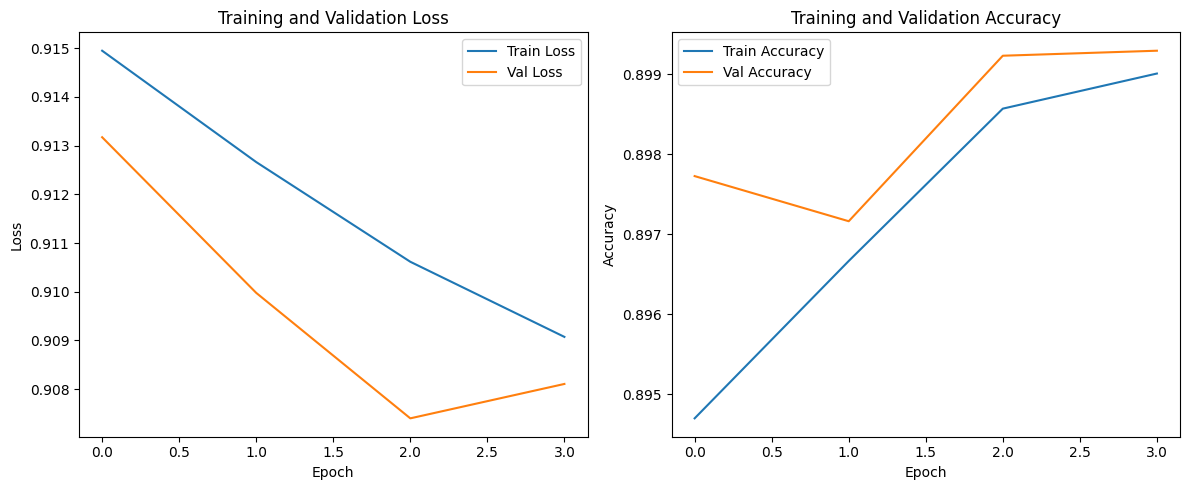

Оценка: 100%|██████████| 499/499 [00:27<00:00, 18.02it/s]


Финальные метрики на тестовом наборе:
Точность: 0.8972
F1-меры: 0.0273
ROC-AUC: 0.5046
PR-AUC: 0.1074


In [26]:
# Графики обучения
plt.figure(figsize=(12, 5))  # Создаем фигуру с размером 12x5 для двух подграфиков

# Первый подграфик: Loss
plt.subplot(1, 2, 1)  # Создаем первый подграфик (1 строка, 2 столбца, первый подграфик)
plt.plot([x[0] for x in train_history], label='Train Loss')  # Строим график для потерь на обучающей выборке
plt.plot([x[0] for x in val_history], label='Val Loss')  # Строим график для потерь на валидационной выборке
plt.title('Training and Validation Loss')  # Заголовок графика
plt.xlabel('Epoch')  # Подпись оси X (номер эпохи)
plt.ylabel('Loss')  # Подпись оси Y (потери)
plt.legend()  # Добавляем легенду для графиков

# Второй подграфик: Accuracy
plt.subplot(1, 2, 2)  # Создаем второй подграфик (1 строка, 2 столбца, второй подграфик)
plt.plot([x[1] for x in train_history], label='Train Accuracy')  # Строим график для точности на обучающей выборке
plt.plot([x[1] for x in val_history], label='Val Accuracy')  # Строим график для точности на валидационной выборке
plt.title('Training and Validation Accuracy')  # Заголовок графика
plt.xlabel('Epoch')  # Подпись оси X (номер эпохи)
plt.ylabel('Accuracy')  # Подпись оси Y (точность)
plt.legend()  # Добавляем легенду для графиков

plt.tight_layout()  # Устанавливаем оптимальные отступы между подграфиками
plt.show()  # Показываем графики

# Загрузка лучшей модели
model.load_state_dict(torch.load('best_model.pth'))  # Загружаем веса модели из файла 'best_model.pth'

# Финальная оценка на тестовом наборе
test_loss, test_acc, test_f1, test_roc_auc, test_pr_auc = eval_model(model, test_loader, criterion, device)  # Оцениваем модель на тестовом наборе данных

# Выводим финальные результаты
print(f'Финальные метрики на тестовом наборе:')
print(f'Точность: {test_acc:.4f}')  # Выводим точность модели на тестовом наборе
print(f'F1-меры: {test_f1:.4f}')  # Выводим F1-меру модели на тестовом наборе
print(f'ROC-AUC: {test_roc_auc:.4f}')  # Выводим ROC-AUC метрику модели на тестовом наборе
print(f'PR-AUC: {test_pr_auc:.4f}')  # Выводим PR-AUC метрику модели на тестовом наборе


Примеры предсказаний модели:
Текст комментария                                                      | Реальная метка  | Предсказание    | Вероятность    
------------------------------------------------------------------------------------------------------------------------
"

 Keith Lynch 

Should he be on the list?

Top credit it would seem ... | Нетоксичный     | Нетоксичный     | 0.3556         
"

Wow, you're a little touchy aren't you? You also seem to love to ma... | Токсичный       | Нетоксичный     | 0.3556         
"
From the Ordering Information screen in the full version ""Composer ... | Нетоксичный     | Нетоксичный     | 0.3556         
Fuck them all. The SPAs, corrupt administrators and POV pushers win. I... | Токсичный       | Нетоксичный     | 0.3556         
"

 re:Teahouse 

Regarding your comment on the q&a; page about being ... | Нетоксичный     | Нетоксичный     | 0.3556         

Итоговые метрики на тестовом наборе:


Оценка: 100%|██████████| 499/499 [00:27<00:00, 18.22it/s]


Потери  : 0.9100
Точность: 0.8972
F1-мера : 0.0273
ROC-AUC : 0.5046
PR-AUC  : 0.1074


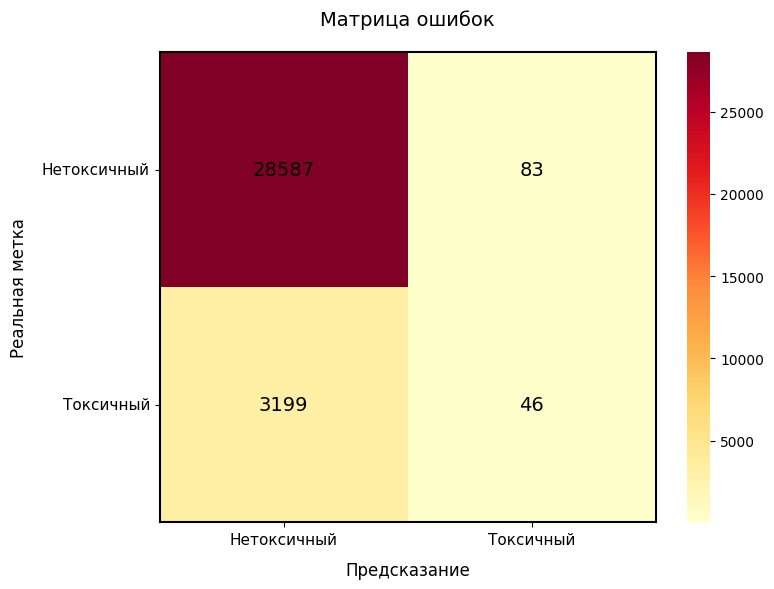

In [36]:
# Загрузка лучшей сохраненной модели
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()  # Переводим модель в режим оценки (отключаем dropout и т.д.)

# Выбор 5 случайных примеров из тестового набора
import random
sample_indices = random.sample(range(len(test_dataset)), 5)  # Генерируем 5 случайных индексов

# Вывод предсказаний для этих примеров с улучшенным форматированием
print("\n\033[1mПримеры предсказаний модели:\033[0m")
# Форматируем заголовок таблицы с цветами (\033[94m - синий) и выравниванием
print("\033[94m{:<70} | {:<15} | {:<15} | {:<15}\033[0m".format(
    "Текст комментария", "Реальная метка", "Предсказание", "Вероятность"))
print("\033[90m" + "-" * 120 + "\033[0m")  # Серая разделительная линия

for idx in sample_indices:
    sample = test_dataset[idx]  # Берем пример из тестового набора по индексу
    with torch.no_grad():  # Отключаем вычисление градиентов для экономии памяти
        # Передаем данные через модель (добавляем размерность batch с помощью unsqueeze)
        output = model(sample['input_ids'].unsqueeze(0).to(device), 
                      sample['attention_mask'].unsqueeze(0).to(device))
        prob = torch.sigmoid(output).item()  # Преобразуем выход в вероятность
        prediction = 1 if prob > 0.5 else 0  # Бинарное предсказание по порогу 0.5
    
    # Обрезаем текст для удобства отображения (первые 70 символов)
    text = test_df.iloc[idx]['comment_text'][:70] + "..." if len(test_df.iloc[idx]['comment_text']) > 70 else test_df.iloc[idx]['comment_text']
    true_label = int(test_df.iloc[idx]['toxic'])  # Получаем истинную метку
    
    # Цветовое выделение правильных/неправильных предсказаний
    correct = (true_label == prediction)
    text_color = "\033[92m" if correct else "\033[91m"  # Зеленый/красный цвет
    
    # Форматированный вывод строки с результатами
    print(f"{text_color}{text:<70}\033[0m | "
          f"{'Токсичный' if true_label else 'Нетоксичный':<15} | "
          f"{'Токсичный' if prediction else 'Нетоксичный':<15} | "
          f"\033[93m{prob:<15.4f}\033[0m")  # \033[93m - желтый цвет для вероятности

# Вывод итоговых метрик на тестовом наборе с цветовым оформлением
print("\n\033[1mИтоговые метрики на тестовом наборе:\033[0m")
# Вычисляем метрики с помощью функции eval_model
val_loss, val_acc, val_f1, val_roc_auc, val_pr_auc = eval_model(model, test_loader, criterion, device)

# Словарь с метриками для удобного вывода
metrics = {
    "Потери": val_loss,
    "Точность": val_acc,
    "F1-мера": val_f1,
    "ROC-AUC": val_roc_auc,
    "PR-AUC": val_pr_auc
}

max_metric_length = max(len(key) for key in metrics.keys())  # Макс. длина названий метрик для выравнивания

for name, value in metrics.items():
    # Градация цвета в зависимости от значения метрики (для некоторых метрик)
    if name in ["Точность", "F1-мера", "ROC-AUC", "PR-AUC"]:
        color_code = 32 + int((value * 60))  # Цвет от зеленого (32) к желтому (92)
        value_str = f"\033[38;5;{color_code}m{value:.4f}\033[0m"
    else:
        value_str = f"{value:.4f}"
    
    # Вывод метрики с цветным значением
    print(f"\033[94m{name:<{max_metric_length}}\033[0m: {value_str}")

# Улучшенная матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Настройка стиля графика
rcParams['font.family'] = 'DejaVu Sans'  # Шрифт с поддержкой кириллицы
plt.style.use('seaborn-v0_8-pastel')  # Стиль графика

all_labels = []  # Список для хранения истинных меток
all_preds = []   # Список для хранения предсказаний

# Собираем все предсказания и метки
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids, attention_mask)
        probs = torch.sigmoid(outputs)  # Получаем вероятности
        preds = (probs > 0.5).int()    # Преобразуем в бинарные предсказания
        
        all_labels.extend(labels.cpu().numpy())  # Переносим на CPU и добавляем в список
        all_preds.extend(preds.cpu().numpy())

# Строим матрицу ошибок
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))  # Размер графика
# Тепловая карта матрицы ошибок
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=['Нетоксичный', 'Токсичный'], 
            yticklabels=['Нетоксичный', 'Токсичный'],
            annot_kws={"size": 14, "color": "black"})

# Настройка подписей
plt.xlabel('Предсказание', fontsize=12, labelpad=10)
plt.ylabel('Реальная метка', fontsize=12, labelpad=10)
plt.title('Матрица ошибок', fontsize=14, pad=20)
plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)

# Добавление рамки вокруг тепловой карты
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()  # Оптимизация расположения элементов
plt.show()  # Отображение графика